# World Simulator - Quick Start Demo

This notebook demonstrates the basic usage of the RSL World simulator.

In [5]:
# Setup path if needed
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import world modules
from world.core import Lattice, Rule, RuleSet, EvolutionEngine
from world.rsl import TensionCalculator, CapacityCalculator, F1Filter

print("Imports successful!")

Imports successful!


## 1. Creating a Lattice

The lattice is a 1D array of spins with periodic boundary conditions.

In [6]:
# Create random lattice
size = 100
lattice = Lattice.random(size, p_plus=0.5)

print(f"Lattice size: {len(lattice)}")
print(f"Initial magnetization: {lattice.magnetization():.4f}")
print(f"First 20 sites: {lattice.sites[:20]}")
print(f"Domain walls: {lattice.domain_wall_count()}")

Lattice size: 100
Initial magnetization: -0.0800
First 20 sites: [-1 -1  1  1  1 -1 -1 -1  1 -1  1  1  1  1 -1  1  1  1 -1 -1]
Domain walls: 48


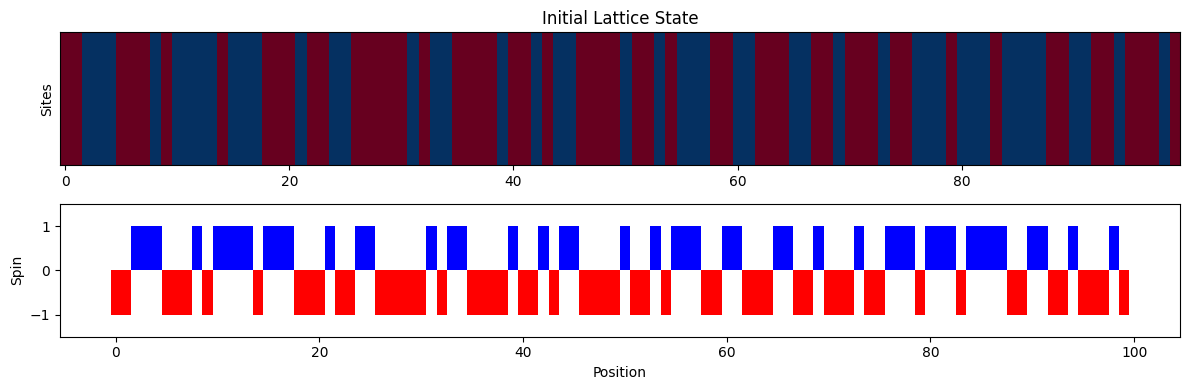

In [7]:
# Visualize initial state
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

# Sites as colormap
axes[0].imshow(lattice.sites.reshape(1, -1), cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
axes[0].set_ylabel('Sites')
axes[0].set_yticks([])
axes[0].set_title('Initial Lattice State')

# Sites as bar chart
axes[1].bar(range(len(lattice)), lattice.sites, width=1.0, color=['red' if s < 0 else 'blue' for s in lattice.sites])
axes[1].set_ylabel('Spin')
axes[1].set_xlabel('Position')
axes[1].set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

## 2. Defining Rules

Rules are local rewriting patterns that transform the lattice.

In [8]:
# Create a ruleset
rules = RuleSet()
rules.add(Rule(name="exchange_pm", pattern=[1, -1], replacement=[-1, 1]))    # Exchange: +- -> -+
rules.add(Rule(name="exchange_mp", pattern=[-1, 1], replacement=[1, -1]))    # Reverse exchange
rules.add(Rule(name="growth_p0", pattern=[1, 0], replacement=[1, 1]))        # Growth: +0 -> ++
rules.add(Rule(name="growth_0p", pattern=[0, 1], replacement=[1, 1]))        # Growth: 0+ -> ++
rules.add(Rule(name="growth_m0", pattern=[-1, 0], replacement=[-1, -1]))     # Growth: -0 -> --
rules.add(Rule(name="growth_0m", pattern=[0, -1], replacement=[-1, -1]))     # Growth: 0- -> --

print(f"Number of rules: {len(rules)}")
print("\nRules:")
for rule in rules.rules:
    print(f"  {list(rule.pattern)} -> {list(rule.replacement)}")

Number of rules: 6

Rules:
  [np.int8(1), np.int8(-1)] -> [np.int8(-1), np.int8(1)]
  [np.int8(-1), np.int8(1)] -> [np.int8(1), np.int8(-1)]
  [np.int8(1), np.int8(0)] -> [np.int8(1), np.int8(1)]
  [np.int8(0), np.int8(1)] -> [np.int8(1), np.int8(1)]
  [np.int8(-1), np.int8(0)] -> [np.int8(-1), np.int8(-1)]
  [np.int8(0), np.int8(-1)] -> [np.int8(-1), np.int8(-1)]


## 3. Running Evolution

The evolution engine applies rules deterministically from left to right.

In [10]:
# Create fresh lattice
lattice = Lattice.random(100, p_plus=0.5, seed=42)

# Create engine
engine = EvolutionEngine(rules)

# Run for 100 steps with history recording
result = engine.run(lattice, max_steps=100, store_history=True)

print(f"Evolved for {len(result.history)} steps")
print(f"Final magnetization: {lattice.magnetization():.4f}")
print(f"Rules applied: {result.stats.rules_applied}")

Evolved for 18 steps
Final magnetization: 0.0600
Rules applied: 737


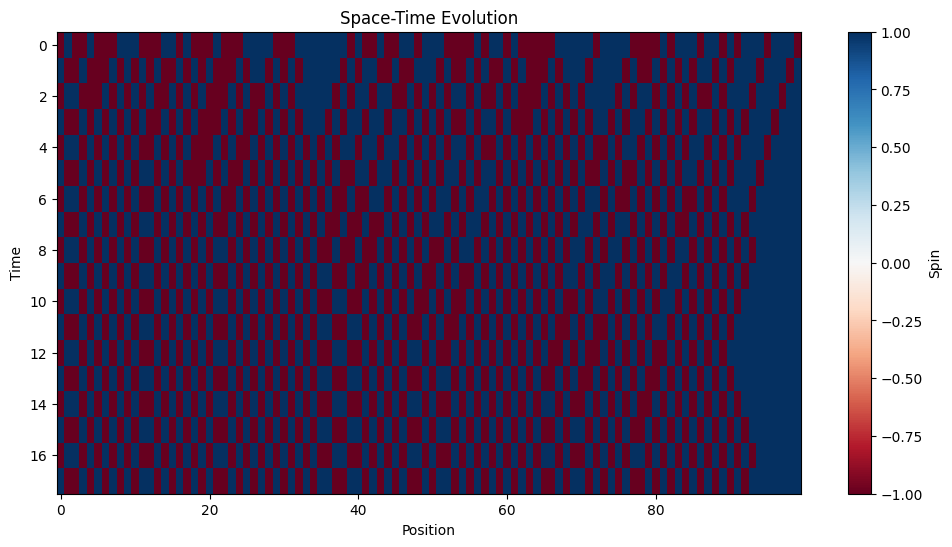

In [11]:
# Visualize evolution (space-time diagram)
history_array = np.array([h.sites for h in result.history])

plt.figure(figsize=(12, 6))
plt.imshow(history_array, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Spin')
plt.xlabel('Position')
plt.ylabel('Time')
plt.title('Space-Time Evolution')
plt.show()

## 4. RSL Mechanism

Calculate tension and capacity according to RSL theory.

In [12]:
# Configure RSL parameters
from world.config import RSLParams
rsl_config = RSLParams(J=1.0, C0=2.0, alpha=0.5, H_threshold=0.5)

# Create calculators
tension_calc = TensionCalculator(J=rsl_config.J)
capacity_calc = CapacityCalculator(C0=rsl_config.C0, alpha=rsl_config.alpha)
f1_filter = F1Filter(threshold=rsl_config.H_threshold)

# Calculate for current lattice
H = tension_calc.global_tension(lattice.sites)
local_h = tension_calc.local_tension(lattice.sites)
capacities = capacity_calc.local_capacity(lattice.sites)
passes_f1 = f1_filter.passes(lattice)

print(f"Global tension H = {H:.2f}")
print(f"Mean local tension = {np.mean(local_h):.4f}")
print(f"Passes F1 filter (no high tension): {passes_f1}")

Global tension H = 82.00
Mean local tension = 0.8200
Passes F1 filter (no high tension): False


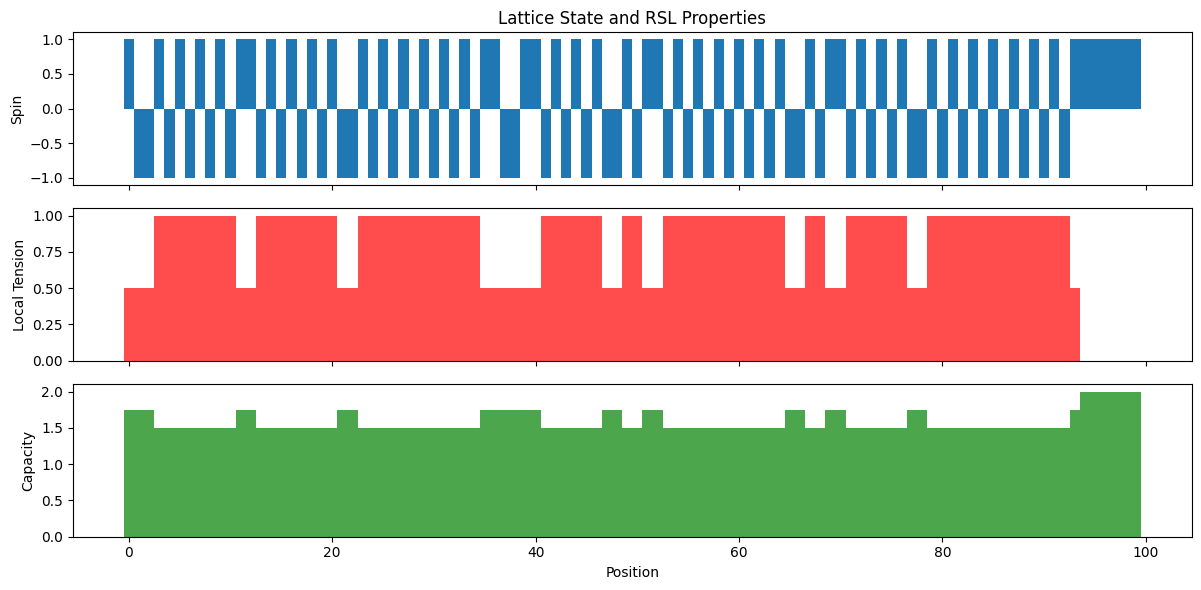

In [13]:
# Visualize local tension and capacity
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

axes[0].bar(range(len(lattice)), lattice.sites, width=1.0)
axes[0].set_ylabel('Spin')
axes[0].set_title('Lattice State and RSL Properties')

axes[1].bar(range(len(local_h)), local_h, width=1.0, color='red', alpha=0.7)
axes[1].set_ylabel('Local Tension')

axes[2].bar(range(len(capacities)), capacities, width=1.0, color='green', alpha=0.7)
axes[2].set_ylabel('Capacity')
axes[2].set_xlabel('Position')

plt.tight_layout()
plt.show()

## 5. Time Series Analysis

Track observables over evolution time.

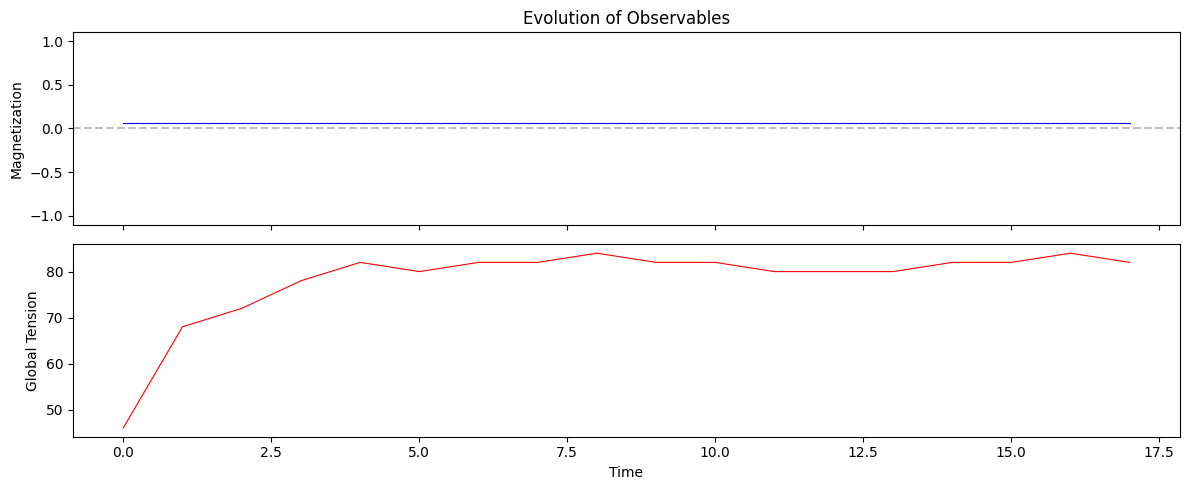

In [15]:
# Calculate observables for history
magnetizations = [np.mean(h.sites) for h in result.history]
tensions = [tension_calc.global_tension(h.sites) for h in result.history]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

axes[0].plot(magnetizations, 'b-', linewidth=0.8)
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Magnetization')
axes[0].set_ylim(-1.1, 1.1)
axes[0].set_title('Evolution of Observables')

axes[1].plot(tensions, 'r-', linewidth=0.8)
axes[1].set_ylabel('Global Tension')
axes[1].set_xlabel('Time')

plt.tight_layout()
plt.show()

## 6. Topological Analysis

In [16]:
from world.analysis import compute_winding_numbers, count_defects, compute_order_parameter

# Compute topological invariants
winding = compute_winding_numbers(lattice)
defects = count_defects(lattice)
order_param = compute_order_parameter(lattice)

print(f"Winding numbers: {winding}")
print(f"Defects: {defects}")
print(f"Order parameter: {order_param:.4f}")

Winding numbers: {'total': np.int8(0)}
Defects: {'domain_walls': 82}
Order parameter: 0.0600


## 7. Omega Cycle Detection

In [17]:
from world.omega import CycleDetector

# Create structured lattice for cycle detection
lattice_structured = Lattice.from_array(np.array([1]*20 + [-1]*20 + [1]*20 + [-1]*20 + [1]*20))

# Detect cycles by evolving and tracking
detector = CycleDetector(window_size=5, max_period=50)

# Simulate evolution and update detector
engine2 = EvolutionEngine(rules)
for t in range(50):
    detector.update(lattice_structured.sites, time=t)
    engine2.step(lattice_structured)

cycles = detector.detected_cycles
print(f"Found {len(cycles)} cycles")
for i, cycle in enumerate(cycles[:5]):  # Show first 5
    print(f"  Cycle {i}: position={cycle.position:.1f}, period={cycle.period}")

Found 228 cycles
  Cycle 0: position=0.0, period=2
  Cycle 1: position=5.0, period=2
  Cycle 2: position=10.0, period=2
  Cycle 3: position=26.0, period=2
  Cycle 4: position=31.0, period=2


## 8. 3D Projection

In [19]:
from world.observer import HilbertMapper

# Create mapper
mapper = HilbertMapper(order=3)  # 8x8x8 = 512 points

# Create lattice with 512 points
lattice_3d = Lattice.random(512, p_plus=0.5, seed=123)

# Map to 3D using map_all() method
positions_3d = mapper.map_all(len(lattice_3d))

print(f"Mapped {len(lattice_3d)} 1D points to 3D")
print(f"3D positions shape: {positions_3d.shape}")
print(f"Coordinate range: [{positions_3d.min():.3f}, {positions_3d.max():.3f}]")

Mapped 512 1D points to 3D
3D positions shape: (512, 3)
Coordinate range: [0.000, 0.875]


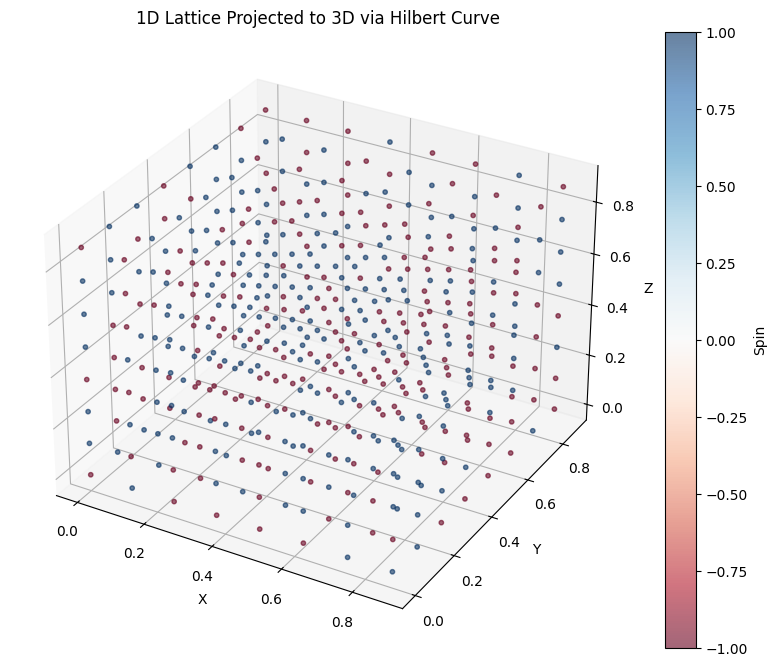

In [20]:
# 3D visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Color by spin value
scatter = ax.scatter(
    positions_3d[:, 0],
    positions_3d[:, 1],
    positions_3d[:, 2],
    c=lattice_3d.sites,
    cmap='RdBu',
    s=10,
    alpha=0.6,
)

plt.colorbar(scatter, label='Spin')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('1D Lattice Projected to 3D via Hilbert Curve')
plt.show()

## 9. Full Simulation with Analysis

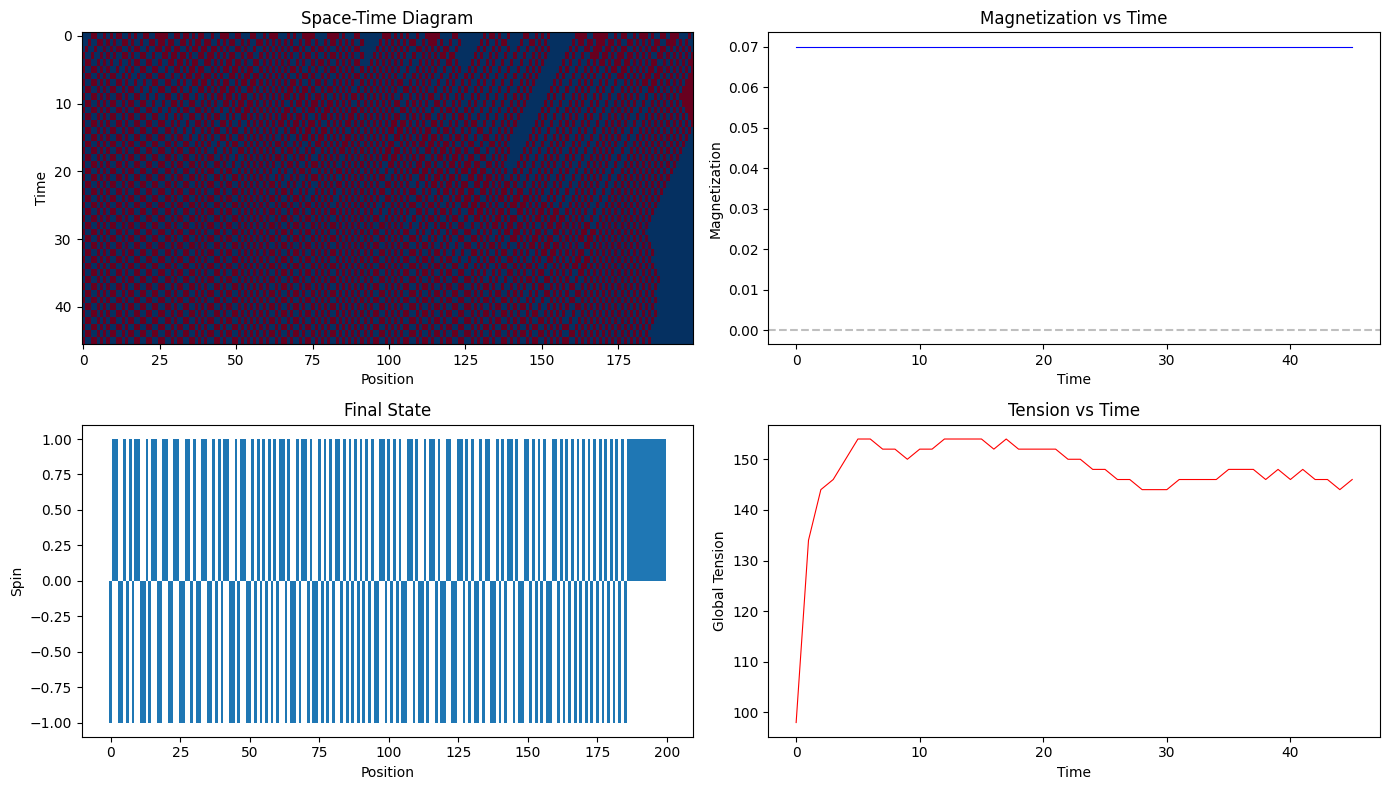

Simulation complete: 46 steps, 4008 rules applied


In [21]:
# Run longer simulation
lattice_long = Lattice.random(200, p_plus=0.5, seed=456)
engine_long = EvolutionEngine(rules)
result_long = engine_long.run(lattice_long, max_steps=500, store_history=True)

# Generate summary plot
history_array = np.array([h.sites for h in result_long.history])

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Space-time diagram
axes[0, 0].imshow(history_array, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
axes[0, 0].set_xlabel('Position')
axes[0, 0].set_ylabel('Time')
axes[0, 0].set_title('Space-Time Diagram')

# Magnetization
mags = [np.mean(h.sites) for h in result_long.history]
axes[0, 1].plot(mags, 'b-', linewidth=0.8)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Magnetization')
axes[0, 1].set_title('Magnetization vs Time')
axes[0, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)

# Final state
axes[1, 0].bar(range(len(lattice_long)), lattice_long.sites, width=1.0)
axes[1, 0].set_xlabel('Position')
axes[1, 0].set_ylabel('Spin')
axes[1, 0].set_title('Final State')

# Tension evolution
tensions = [tension_calc.global_tension(h.sites) for h in result_long.history]
axes[1, 1].plot(tensions, 'r-', linewidth=0.8)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Global Tension')
axes[1, 1].set_title('Tension vs Time')

plt.tight_layout()
plt.show()

print(f"Simulation complete: {len(result_long.history)} steps, {result_long.stats.rules_applied} rules applied")

## Next Steps

- Try different rule sets
- Explore parameter space with `world.exploration`
- Analyze phase transitions
- Study emergent symmetries in omega cycles
- Compare with Standard Model predictions